<a href="https://colab.research.google.com/github/Donaldwic/Pair-trading/blob/main/Pair_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
!pip install statsmodels
!pip install tensorboardX


In [245]:
pip install scikit-learn

In [246]:
pip install --upgrade pip setuptools wheel


In [247]:
# Install Backtesting.py
!pip install backtesting

# Install Backtrader
!pip install backtrader

# Install PyAlgoTrade
!pip install pyalgotrade


# Import & cleaning data

In [248]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint

# Define parameters
start_date = '2022-01-01'
end_date = '2024-12-25'
instrument_ids = ['BTC-USD', 'MSTR', 'MARA', 'BLK', 'RIOT', 'TSLA']

# Fetch data using yfinance
data_frames = []
for instrument in instrument_ids:
    df = yf.download(instrument, start=start_date, end=end_date, progress=False)
    df['Ticker'] = instrument
    data_frames.append(df)

# Combine data into a single DataFrame
all_data = pd.concat(data_frames)

# Create a pivot table to replicate 'adjClose' feature
adj_close_data = all_data.pivot_table(index=all_data.index, columns='Ticker', values='Adj Close')

adj_close_data.columns = adj_close_data.columns.get_level_values(0)

# Ensure the index includes only stock trading days
# Use a stock (e.g., 'MSTR') as a reference for stock trading days
stock_days = adj_close_data['MSTR'].dropna().index

# Filter Bitcoin data to include only stock trading days
btc_stock_days = adj_close_data.loc[stock_days, 'BTC-USD']

# Combine Bitcoin and stock data for only trading days
adj_close_filtered = adj_close_data.loc[stock_days]

# Display the filtered data
print(adj_close_filtered.head())


Ticker             BLK       BTC-USD       MARA       MSTR       RIOT  \
Date                                                                    
2022-01-03  841.542542  46458.117188  32.889999  55.826000  22.740000   
2022-01-04  846.609802  45897.574219  34.130001  55.106998  24.379999   
2022-01-05  823.119019  43569.003906  29.620001  50.910000  21.440001   
2022-01-06  826.552551  43160.929688  29.299999  49.862000  20.480000   
2022-01-07  823.580505  41557.902344  28.490000  48.294998  20.360001   

Ticker            TSLA  
Date                    
2022-01-03  399.926666  
2022-01-04  383.196655  
2022-01-05  362.706665  
2022-01-06  354.899994  
2022-01-07  342.320007  


<ipython-input-248-40e941c4c904>:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  adj_close_data = all_data.pivot_table(index=all_data.index, columns='Ticker', values='Adj Close')


In [249]:
adj_close_filtered.shape

(749, 6)

Divide data for training and testing

In [250]:
train_range = (adj_close_filtered.shape[0]*7//10) #
train_data = adj_close_filtered.iloc[:train_range]
test_data = adj_close_filtered.iloc[train_range:]

In [251]:
# Function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    scores = np.zeros((n, n))
    pvalues = np.ones((n, n))
    pairs = []

    for i in range(n):
        for j in range(i, n):
            stock1 = data.iloc[:, i]
            stock2 = data.iloc[:, j]
            score, pvalue, _ = coint(stock1, stock2)
            scores[i, j] = score
            pvalues[i, j] = pvalue
            if pvalue < 0.05 and data.columns[i]!=data.columns[j]:  # Adjust significance level as needed
                pairs.append((data.columns[i], data.columns[j]))

    return scores, pvalues, pairs

Finding which pair has p-value < 0.05, it can be statistically indicated a significant effect or relationship of each others.

<ipython-input-251-e7a8f3857b25>:12: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  score, pvalue, _ = coint(stock1, stock2)
<ipython-input-251-e7a8f3857b25>:12: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  score, pvalue, _ = coint(stock1, stock2)
<ipython-input-251-e7a8f3857b25>:12: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  score, pvalue, _ = coint(stock1, stock2)
<ipython-input-251-e7a8f3857b25>:12: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  score, pvalue, _ = coint(stock1, stock2)
<ipython-input-251-e7a8f3857b25>:12: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  score, pvalue, _ = coint(stock1, stock2)
<ipython-input-251-e7a8f3857b25>:12: Col

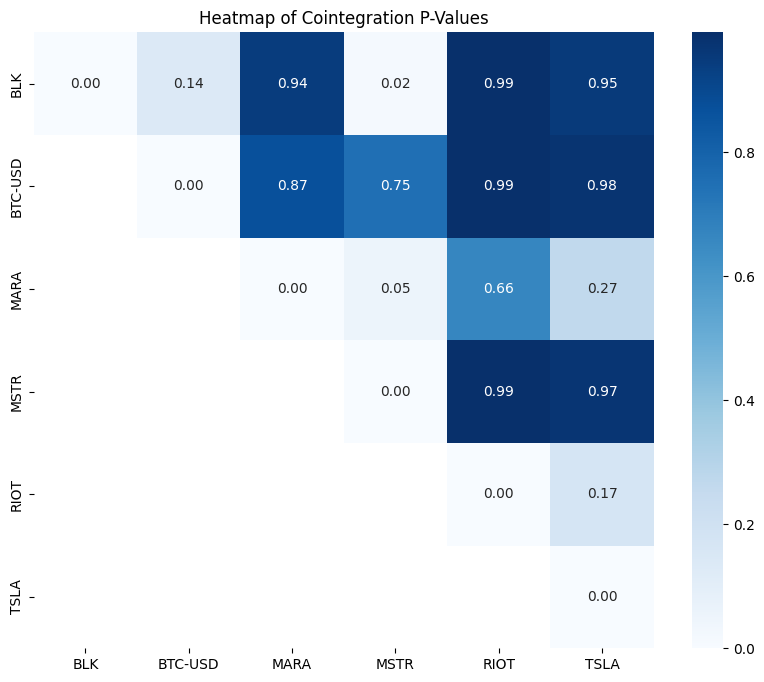

Cointegrated Pairs with P-value < 0.05:
[('BLK', 'MSTR')]


In [252]:
# Generate p-values for cointegration test
scores, pvalues, pairs = find_cointegrated_pairs(adj_close_filtered)

# Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(pvalues,
            xticklabels=adj_close_filtered.columns,
            yticklabels=adj_close_filtered.columns,
            cmap='Blues',
            mask=(pvalues >= 1),  # Mask high p-values
            annot=True,             # Annotate p-values
            fmt=".2f"               # Format for annotations
           )
plt.title('Heatmap of Cointegration P-Values')
plt.show()

# Display pairs with significant cointegration
print("Cointegrated Pairs with P-value < 0.05:")
print(pairs)

In [253]:
pair_1= 'BLK'
pair_2= 'MSTR'

0.016604236711594195


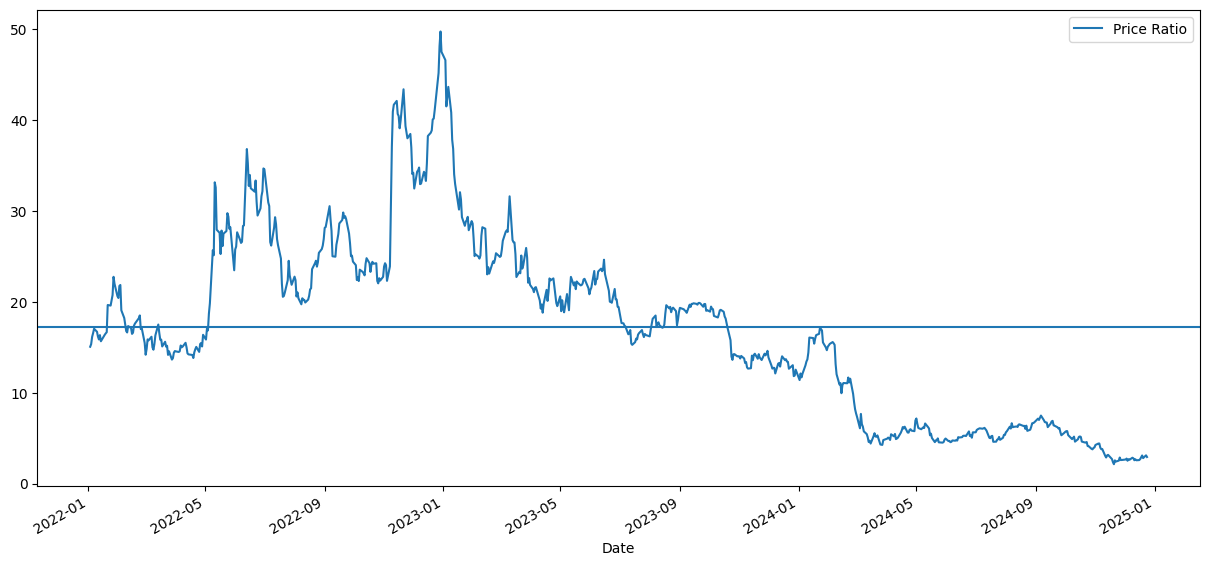

In [254]:
S1 = adj_close_filtered[pair_1]
S2 = adj_close_filtered[pair_2]
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [255]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

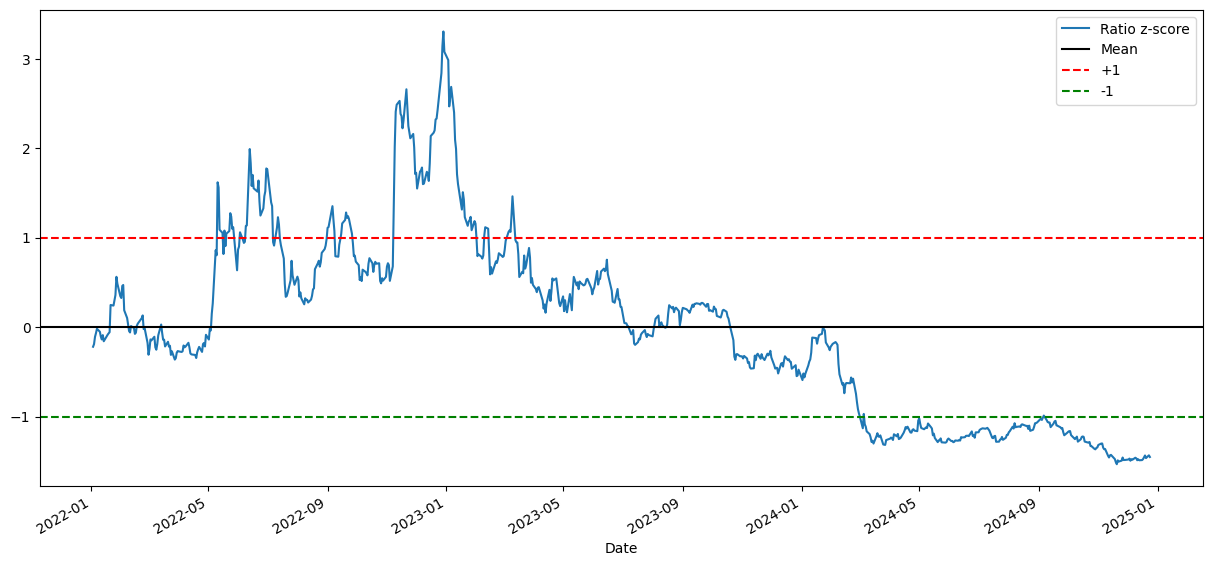

In [256]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [257]:
ratios = adj_close_filtered[pair_1] / adj_close_filtered[pair_2]
print(len(ratios))
train = ratios[:train_range]
test = ratios[train_range:]

749


Plot moving average

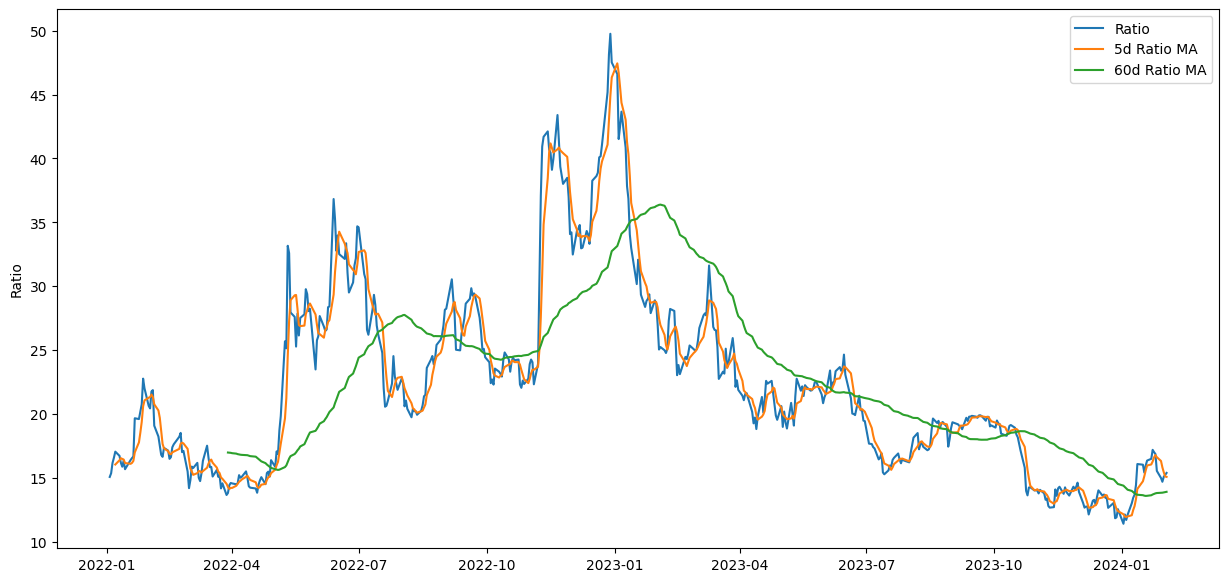

In [258]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

# Z-score
The z-score standardizes data, identifies outliers, calculates probabilities in a normal distribution, aids in hypothesis testing, compares values across scales, and is used in financial risk management.

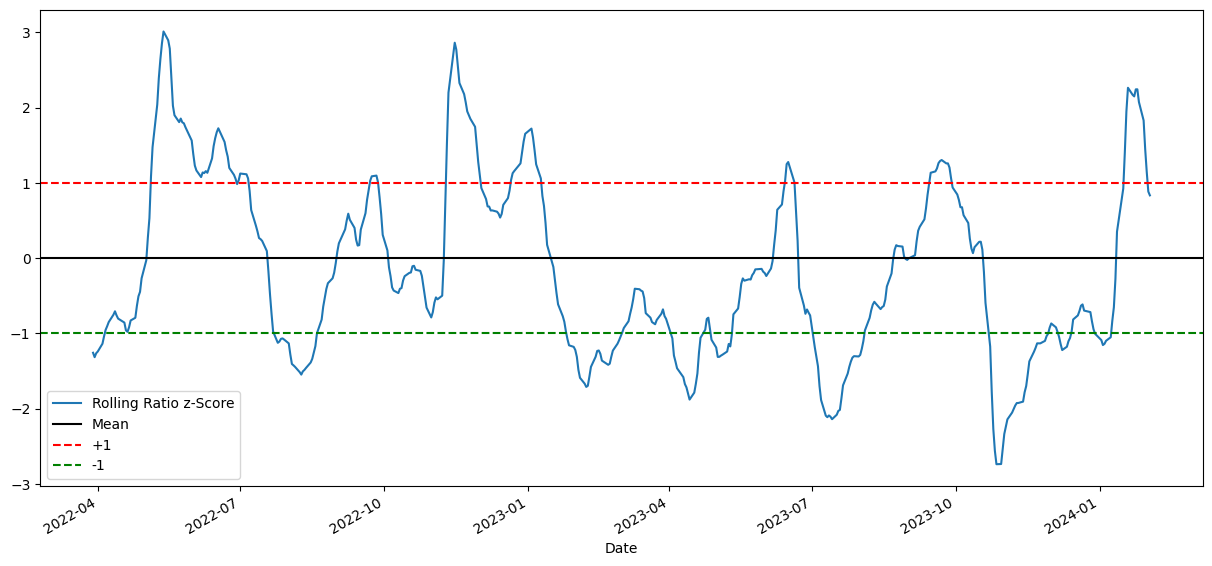

In [259]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

#Strategy

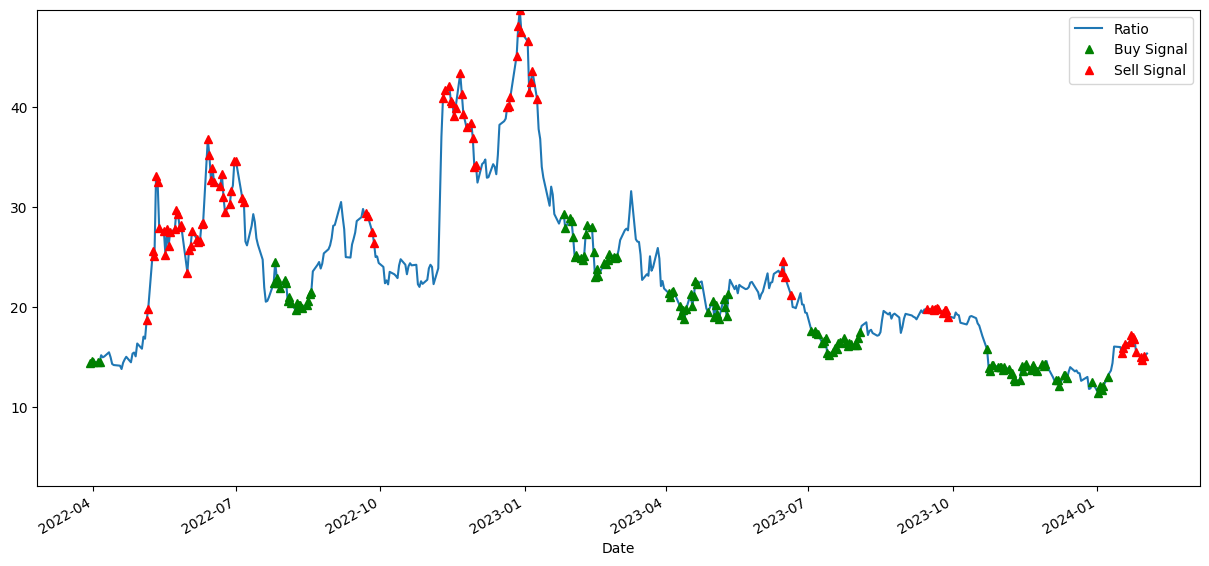

In [260]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

Sell or Short when the price is higher than the mean equal 1 S.D.,
Buy or Long when the price is lower than the mean equal 1 S.D.

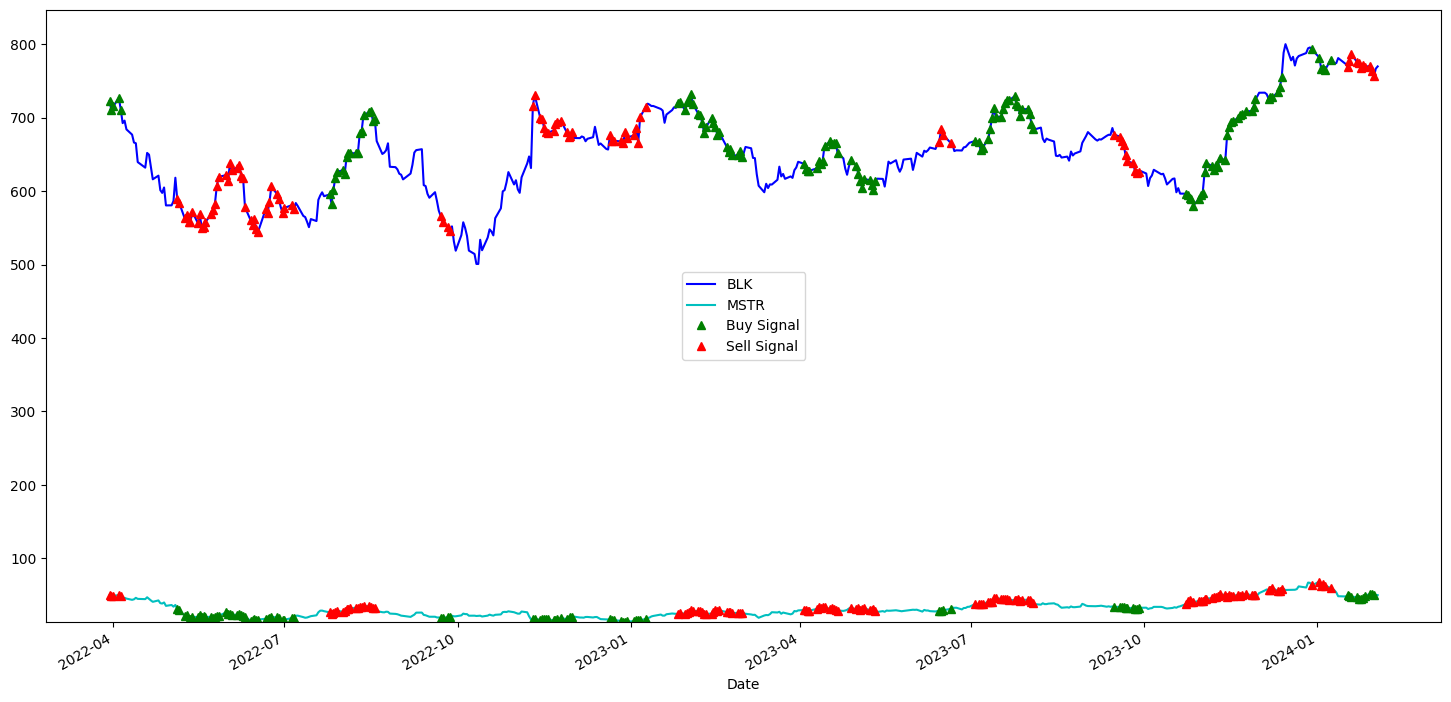

In [261]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = adj_close_filtered[pair_1].iloc[:train_range]
S2 = adj_close_filtered[pair_2].iloc[:train_range]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend([pair_1,pair_2, 'Buy Signal', 'Sell Signal'])
plt.show()


In [262]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return [0]
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2 #price ratio
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    cumulative_money=[]
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            cumulative_money.append(money)
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            cumulative_money.append(money)
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2 #take money back from stock market and wait for new cycle
            countS1 = 0
            countS2 = 0
            cumulative_money.append(money)
        else:
            cumulative_money.append(money) #just hold when z-score between -1 and -0.5 or between 0.5 and 1
#print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return cumulative_money


print('Profit is:',trade(adj_close_filtered[pair_1].iloc[:train_range], adj_close_filtered[pair_2].iloc[:train_range], 5, 60)[-1])

Profit is: 15553.970386821944


<ipython-input-262-8336b3a99729>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:
<ipython-input-262-8336b3a99729>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:
<ipython-input-262-8336b3a99729>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.5:
<ipython-input-262-8336b3a99729>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

In [263]:
print("Profit is:",trade(adj_close_filtered[pair_1].iloc[:train_range], adj_close_filtered[pair_2].iloc[:train_range], 5, 90)[-1])

Profit is: 26323.869681006603


<ipython-input-262-8336b3a99729>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:
<ipython-input-262-8336b3a99729>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:
<ipython-input-262-8336b3a99729>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.5:
<ipython-input-262-8336b3a99729>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

# Find optimal window

In [264]:
# Find the window length 0-254
# that gives the highest returns using this strategy
length_scores=[]
for l in range(1,255):
    length_scores.append(trade(adj_close_filtered[pair_1].iloc[:train_range],
                               adj_close_filtered[pair_2].iloc[:train_range], 5, l)[-1])
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

<ipython-input-262-8336b3a99729>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:
<ipython-input-262-8336b3a99729>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:
<ipython-input-262-8336b3a99729>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.5:
<ipython-input-262-8336b3a99729>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

Best window length: 107


#Plot profit & loss (train data)

<ipython-input-262-8336b3a99729>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:
<ipython-input-262-8336b3a99729>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:
<ipython-input-262-8336b3a99729>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.5:
<ipython-input-262-8336b3a99729>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

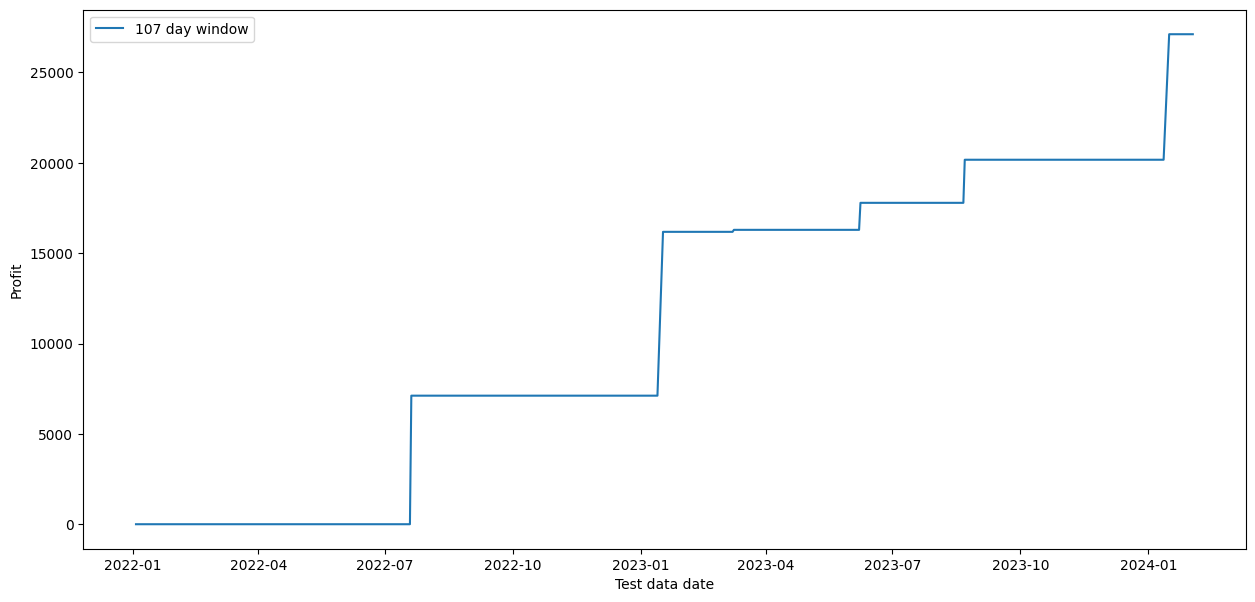

In [265]:
profit_1=trade(adj_close_filtered[pair_1].iloc[:train_range], adj_close_filtered[pair_2].iloc[:train_range], 5, best_length)
plt.figure(figsize=(15,7))
plt.plot(adj_close_filtered.iloc[:train_range].index,profit_1,linewidth=1.5)
plt.xlabel('Test data date')
plt.ylabel('Profit')
plt.legend([f'{best_length} day window', f'{best_length2} day window'])
plt.show()

In [266]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(adj_close_filtered[pair_1].iloc[train_range:],
                  adj_close_filtered[pair_2].iloc[train_range:],5, l)[-1]
                  for l in range(1,255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset,
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

<ipython-input-262-8336b3a99729>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:
<ipython-input-262-8336b3a99729>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:
<ipython-input-262-8336b3a99729>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.5:
<ipython-input-262-8336b3a99729>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

107 day window: 4735.296858001064
78 day window: 5011.065286443236


# Plot provit & loss (test data)

<ipython-input-262-8336b3a99729>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] > 1:
<ipython-input-262-8336b3a99729>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] < -1:
<ipython-input-262-8336b3a99729>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(zscore[i]) < 0.5:
<ipython-input-262-8336b3a99729>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

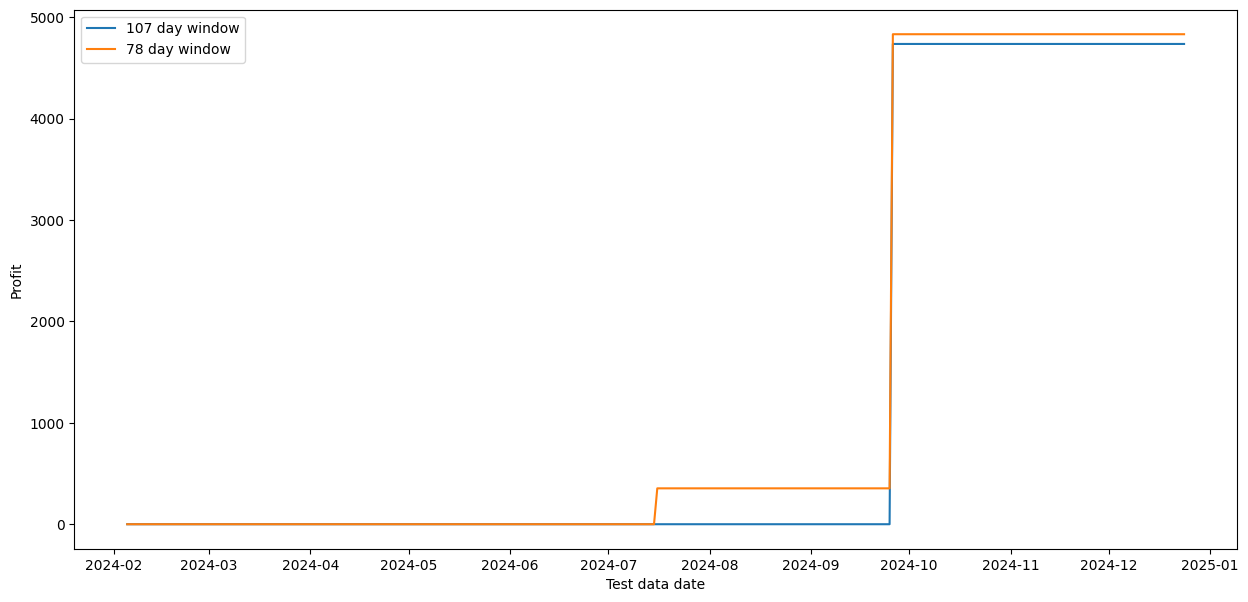

In [269]:
profit_1=trade(adj_close_filtered[pair_1].iloc[train_range:], adj_close_filtered[pair_2].iloc[train_range:], 5, best_length)
profit_2=trade(adj_close_filtered[pair_1].iloc[train_range:], adj_close_filtered[pair_2].iloc[train_range:], 5, best_length2)
plt.figure(figsize=(15,7))
plt.plot(adj_close_filtered.iloc[train_range:].index,profit_1,linewidth=1.5)
plt.plot(adj_close_filtered.iloc[train_range:].index,profit_2,linewidth=1.5)
plt.xlabel('Test data date')
plt.ylabel('Profit')
plt.legend([f'{best_length} day window', f'{best_length2} day window'])
plt.show()